# Measures of effect

These exercises will utilize the [tidyverse](https://www.tidyverse.org/) style of `R`, so let's load the tidyverse package

In [ ]:
library(tidyverse)

## Aim

The aim of this practical is to introduce the Stata commands used to calculate the main measures of disease and effect used in epidemiology: risks, risk ratios, rates, rate ratios, and odds ratios.

## Reading in the data and initial examination

For the first part of this practical session we will use data from the Whitehall study (whitehall.dta).

To read in the `STATA` formatted dataset use the `read_dta` function from the `haven` package.

In [ ]:
library(haven)

In [ ]:
whitehall_df <- read_dta("Data_files-20211113/WHITEHALL.dta")

In [ ]:
head(whitehall_df)

### We are going to examine the effect of smoking on mortality from any cause. all is the variable name for all cause mortality

**all**

coded: 1=death from any cause; 0=alive smok is the variable name for smoking category

**smok** 

coded: 1=never smoked; 2=ex-smoker; 3=1-14 cigarettes per day; 4=15-24 cigarettes per day; 5=25+ cigarettes per day

To find out how many deaths from all causes there were we need to create a table. Basic tables in R are functional but don't give much extra information. Type:

In [ ]:
table(whitehall_df$all)

More expressive tables can be printed with the `CrossTable` function from the `gmodels` package.

In [ ]:
library(gmodels)

In [ ]:
CrossTable(whitehall_df$all)

There were 403 deaths from all causes (24.03%).

Similarly to see the distribution of the cohort for smoking categories, type:

In [ ]:
CrossTable(whitehall_df$smok)

So, there were 317 men who had never smoked, 646 ex-smokers, etc.

To split the cohort into current smokers and non-smokers we must create a new variable that takes the values 0 for never or ex-smokers and 1 for smokers. To do this use the following commands:

In [ ]:
whitehall_df_2 <- whitehall_df %>%
    mutate(smok2 = case_when(smok == 1 ~ 0,
                             smok == 2 ~ 0,
                             smok == 3 ~ 1,
                             smok == 4 ~ 1,
                             smok == 5 ~ 1))

It is good practice always to check that the new variable has been coded correctly. We can do this by tabulating it against the old one. 

Type:

In [ ]:
CrossTable(whitehall_df_2$smok, whitehall_df_2$smok2)

So those who never smoked and the ex-smokers are coded as 0 in smok2 and anyone who smokes at least one cigarette is coded as 1.

# Calculation of risks and risk ratios

There are 2 ways we can obtain risks, the third also gives risk ratios automatically.

▪ To examine the risk of death according to smoking status we can simply use the
CrossTable command. It is easy to obtain risks using this command. Type:

In [ ]:
CrossTable(whitehall_df_2$smok2, whitehall_df_2$all)

The row percentages give the risk

Another way to derive the risk of death is to use the `summarise` function.

In [ ]:
whitehall_df_2 %>% 
    group_by(smok2) %>% # our variable of interest
    summarise( # summarise operation by group
        mean = mean(all),
        std = sd(all),
        freq = length(all)
    )

The risk for non-smokers is the same as before = 0.1745 (17.45%)

Because all is coded 0/1, its mean is the total number of deaths divided by the total number of observations (i.e. the risk).

Mean = $\Sigma   0 + 1 + 0 + ..... / N$ = total number of deaths / total number of observations.

We can also produce a table of risk measures and effect measures using the `epi.2by2` command from `epiR` specifically designed for risks. Type:

In [ ]:
library("epiR")

In [ ]:
epi.2by2(table(factor(whitehall_df_2$smok2, levels = c(1,0)), 
               factor(whitehall_df_2$all, levels = c(1,0))), 
         method = "cohort.count", digits=4)

The risks are 0.329 and 0.174 for smokers and non-smokers respectively and we also have the risk ratio = 1.89 (95% CI 1.59 to 2.24)

The output gives a two-by-two table as the CrossTable command, and below that the risk estimates. Then it gives the risk difference (i.e. risk among exposed minus risk among unexposed), followed by the risk ratio. The final two parameters apply if smoking really is causal. They are the percentage of outcomes among the exposed attributable to the exposure (current smoking) and the percentage of outcomes among the population attributable to the exposure, assuming that our sample accurately represents the percentage of smokers in the population.

## Defining follow-up information

Before we are able to use most of the R commands appropriate for the analysis of follow-up data, we must first define the amount of time between entry and exit into the study and the outcome (or ‘failure’) variable that we'll call `followup_time`.

In [ ]:
whitehall_df_3 <- whitehall_df_2 %>%
    mutate(followup_time = as.numeric(difftime(whitehall_df_2$timeout, 
                                               whitehall_df_2$timein, 
                                               units = "days")) / 365.25)

## Calculation of rates

To obtain all-cause mortality rates for smokers and non-smokers, type:

In [ ]:
library(survival)
library(biostat3)

In [ ]:
survRate(Surv(followup_time, all) ~ smok2, data=whitehall_df_3)

In the output,

**event** gives the number of events (deaths)

**tstop** gives the number of person * years from timein to timout

The **rate** is per year (event/tstop)

The final columns show 95% confidence intervals.

The rate for the combined group of non-smokers and ex-smokers is 0.010 per person-year (168/16362). The rate for smokers is 0.021 per person-year (235/11242).

To obtain the rate per 1000 person-years, type:

In [ ]:
survRate(Surv(followup_time/1000, all) ~ smok2, data=whitehall_df_3)

To obtain all-cause mortality rates for the finer categories of smoking using the original variable for smoking, type:

In [ ]:
survRate(Surv(followup_time/1000, all) ~ smok, data=whitehall_df_3)

Death rates increase in ex-smokers compared to non-smokers, and with increasing quantities smoked.

We can plot a graph of deaths by smoking status:

In [ ]:
survRate(Surv(followup_time/1000, all) ~ smok, data=whitehall_df_3) %>%
    ggplot(aes(x = smok, y = rate)) +
    #Plot the points
    geom_point() +
    #Add in error bars
    geom_errorbar(aes(ymin=lower, ymax=upper))

## Calculation of rate ratios

The `survRate` function provides survival rates. We can obtain the rates for two groups and then divide them to get a rate ratio.

In [ ]:
#Get the rate for non-smokers
smok_0 <- survRate(Surv(followup_time/1000, all) ~ smok2, data=whitehall_df_3) %>%
    filter(smok2 == 0) %>%
    purrr::pluck("rate")

#Get the rate for smokers
smok_1 <- survRate(Surv(followup_time/1000, all) ~ smok2, data=whitehall_df_3) %>%
    filter(smok2 == 1) %>%
    purrr::pluck("rate")

#Get the ratio
smok_1 / smok_0

This does not include 95% confidence intervals or chi-square test like the equivalent `STATA` code with `stmh`

From this we can conclude that smokers have twice the death rate (2.04) of non-smokers. Note that the category with the lower code value (code 0 = never/ex-smokers) is taken as the reference category.

Note that the rate ratio is greater than the risk ratio (1.89) that we calculated earlier. This is because there was less person-time among smokers than non-smokers.

## Calculation of odds ratios

For this part of the practical we will use data from the case-control study of HIV infection in women in Mwanza, Tanzania.

In [ ]:
mwanza_df <- read_dta("Data_files-20211113/MWANZA.dta")

In [ ]:
head(mwanza_df)

We will examine whether there is an association between HIV infection and duration of education.

**case** is the variable name for HIV infection coded: 1=case; 0=control

**ed** is the variable name for level of education coded: 1=no formal education (none/adult only); 2=1-3 years; 3=4-6 years; 4=7+ years

To find out how many cases and controls there were, type:

In [ ]:
CrossTable(mwanza_df$case)

Similarly to see the distribution of women by level of education, type:

In [ ]:
CrossTable(mwanza_df$ed)

To examine the difference in education levels in cases and controls, type:

In [ ]:
CrossTable(mwanza_df$case, mwanza_df$ed, chisq=TRUE)

The `chisq=TRUE` option tests the null hypothesis that the two distributions of education level are the same.

The p-value (P<0.001) provides very strong evidence against the null hypothesis. Those with no education seem to be under-represented among cases relative to controls (26% against 46%). Also note that the group with the highest education (code 4) is small, therefore any estimates of effect for this group will have wide confidence intervals.

Because this is a case-control study, and the cases and controls therefore have different probabilities of selection, we cannot calculate the odds of disease for each education group from the above table. However, we can calculate odds ratios. This will be further explained in Session 4 of the CAL material.

Create a new variable **ed2** which takes the value 1 for women with no formal education and value 2 for those with some education (codes 2-4 of ed).

In [ ]:
mwanza_df <- mwanza_df %>%
    mutate(ed2 = case_when(ed == 1 ~ 1,
                           ed > 1 ~ 2))

To check that the new variable has been coded correctly, tabulate it against the original variable:

In [ ]:
CrossTable(mwanza_df$ed, mwanza_df$ed2)

To derive the odds ratio we use the `oddsratio` command from package `epitools`:

In [ ]:
library(epitools)

In [ ]:
table(mwanza_df$case, mwanza_df$ed2) %>%
    oddsratio()

This shows that the odds of HIV infection in the educated women is 2.41 times that in the uneducated women, with 95% confidence interval 1.68 to 3.50.

It is important to take account of missing values when analysing data. The variable **skin** records skin incisions or tattoos (coded: 1=no, 2=yes, 9=missing).

To tabulate skin and obtain odds ratio estimates, type:

In [ ]:
CrossTable(mwanza_df$skin)

In [ ]:
table(mwanza_df$case, mwanza_df$skin) %>%
    oddsratio

Let's compare to `mhodds` from `STATA`

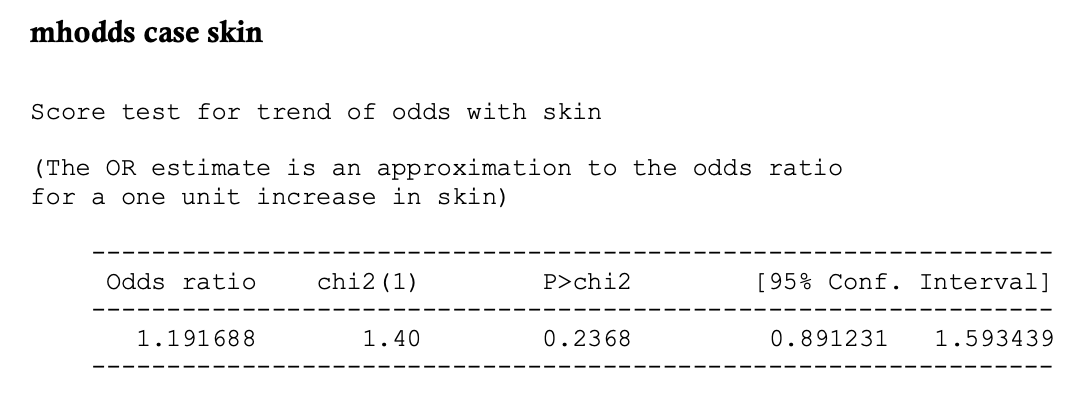

Gives different results than STATA, not sure why...

Now to omit 9. We'll use `epi.2by2` to get more expressive output than `oddsratio`

In [ ]:
epi.2by2(table(factor(mwanza_df$case, levels = c(1,0)), 
               factor(mwanza_df$skin, levels = c(2,1))), 
         method = "case.control", digits=4)

# Review exercise (time for you to have a go...)

### 1) How many men in the dataset died of CHD?

In [ ]:
whitehall_df_2 %>%
    filter(chd == 1) %>%
    nrow

154 deaths from CHD

### 2) What is the risk of death from CHD in each smoking category of smok2?

In [ ]:
epi.2by2(table(factor(whitehall_df_2$smok2, levels = c(1,0)), 
               factor(whitehall_df_2$chd, levels = c(1,0))), 
         method = "cohort.count", digits=4)

Risk of 12.3% in smokers, 6.85% in non-smokers

### 3) What is the risk ratio of current smokers to non-smokers?

From looking at table in answer 2, risk ratio is 1.80

### 4) Use the stset command to define follow-up details for the outcome CHD

Not necessary in `R`

### 5) Use strate to obtain the CHD mortality rates for current smokers and non- smokers.

In [ ]:
survRate(Surv(followup_time, chd) ~ smok2, data=whitehall_df_3)

0.004 per person-year in non-smokers, 0.008 per person-year in smokers

### 6) What is the rate of deaths due to CHD per 1000 person-years for current smokers and non-smokers?

In [ ]:
survRate(Surv(followup_time/1000, chd) ~ smok2, data=whitehall_df_3)

4.034 per 1000 person-years in non-smokers, 7.827 per person-years in smokers

### 7) Use stmh to obtain the rate ratio of CHD death rates for smokers to non-smokers.

In [ ]:
survRate(Surv(followup_time, chd) ~ smok2, data=whitehall_df_3) %>%
    dplyr::select(rate) %>%
    slice(2) %>%
    unlist /
survRate(Surv(followup_time, chd) ~ smok2, data=whitehall_df_3) %>%
    dplyr::select(rate) %>%
    slice(1) %>%
    unlist

Rate ratio is 1.94

### 8) Read in the Mwanza data.

In [ ]:
mwanza_df <- read_dta("Data_files-20211113/MWANZA.dta")

### 9) How many women had ever used a condom (the variable name for condom use is usedc)?

In [ ]:
mwanza_df %>%
    filter(usedc == 2) %>%
    nrow

23 women have used a condom

### 10) What proportion of cases had ever used a condom?

In [ ]:
mwanza_df %>%
    filter(case == 1) %>%
    group_by(usedc) %>%
    summarise(n = n()) %>%
    mutate(proportion = n / sum(n) * 100)

3.70% of cases had used a condom

### 11) Use mhodds to obtain the odds ratio for condom use and HIV infection.

(Remember to account for the missing values for usedc)

In [ ]:
epi.2by2(table(factor(mwanza_df$usedc, levels = c(2,1)), 
               factor(mwanza_df$case, levels = c(1,0))), 
         method = "case.control", digits=4)

Odds ratio of 1.356 